# Multicolour contamination analysis example - simulations

*[Hannu Parviainen](mailto:hannu@iac.es)<br>
Instituto de Astrofísica de Canarias*

Last modified: 24.4.2024

Here we use the `pytransit.contamination` module to estimate the *true planet to star radius ratio* robustly using multicolour photometry in the presence of possible flux contamination from an unresolved source in the photometry aperture, as detailed in [Parviainen et al. 2019](https://www.aanda.org/articles/aa/pdf/2019/10/aa35709-19.pdf). This can be used in the validation of transiting planet candidates, where, e.g., blended eclipsing binaries are a significant source of false positives.

**Light curves:** We don't use real data here, but create simulated multicolour photometry lightcurves using the `MockLC` class found in `src.mocklc`. The code is the same that was used for the simulations in [Parviainen et al. 2019](https://www.aanda.org/articles/aa/pdf/2019/10/aa35709-19.pdf).

**Log posterior function:** The log posterior function is defined by the `MockLPF` class found in `src.blendlpf.MockLPF`. The class inherits `pytransit.lpf.PhysContLPF` and overrides the `_init_instrument` method to define the instrument and the contamination model (amongst other things to make running a variety of simulations smooth).

**Parametrisation:** As discussed in the paper, the contamination is parametrised by the *apparent area ratio* ($k_\mathrm{True}^2$), *true area ratio* ($k_\mathrm{App}^2$), and the effective temperatures of the host and contaminant stars. The *apparent area ratio* defines how deep the transit is in a single single passband and can be wavelength dependent (if the host and contaminant are of different spectral type), while the *true area ratio* stands for the unblended true geometric planet-star area ratio.

The *true radius ratio* ($k_\mathrm{True}$) is the main quantity of interest in transiting planet candidate validation), since it together with a stellar radius estimate gives the true absolute planetary radius. 

In [17]:
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
import sys
import astropy.units as u
import seaborn as sb

from corner import corner
from numpy.random import seed
from pytransit.contamination import true_radius_ratio, apparent_radius_ratio

sys.path.append('.')
import src.plotting as pl 
from src.mocklc import MockLC, SimulationSetup
from src.blendlpf import MockLPF

def cnt(kapp, ktrue):
    return 1 - (kapp/ktrue)**2

seed(0)

rstar = 0.4*u.R_sun
kjup = ((1 * u.R_jup).to(u.R_sun) / rstar).value
k3re = ((3 * u.R_earth).to(u.R_sun) / rstar).value

wn = 0.001
ns = 15000
nr = 10

## An uncontaminated sub-Neptune around an M dwarf

  0 |G| tc             N(μ = 0.0, σ = 0.1)                      [    -inf ..      inf]
  1 |G| p              N(μ = 5.0, σ = 1e-07)                    [    0.00 ..      inf]
  2 |G| rho            U(a = 0.1, b = 25.0)                     [    0.00 ..      inf]
  3 |G| b              U(a = 0.0, b = 1.0)                      [    0.00 ..     1.00]
  4 |P| k2_app         U(a = 0.0001, b = 0.0625)                [    0.00 ..     0.06]
  5 |G| k2_true        U(a = 0.0001, b = 0.5625)                [    0.00 ..      inf]
  6 |G| teff_h         N(μ = 3600.0, σ = 10.0)                  [ 2500.00 .. 12000.00]
  7 |G| teff_c         U(a = 2500, b = 12000)                   [ 2500.00 .. 12000.00]
  8 |P| q1_g'          U(a = 0, b = 1)                          [    0.00 ..     1.00]
  9 |P| q2_g'          U(a = 0, b = 1)                          [    0.00 ..     1.00]
 10 |P| q1_r'          U(a = 0, b = 1)                          [    0.00 ..     1.00]
 11 |P| q2_r'          U(a = 0, b = 1)     

Global optimisation:   0%|          | 0/2000 [00:00<?, ?it/s]

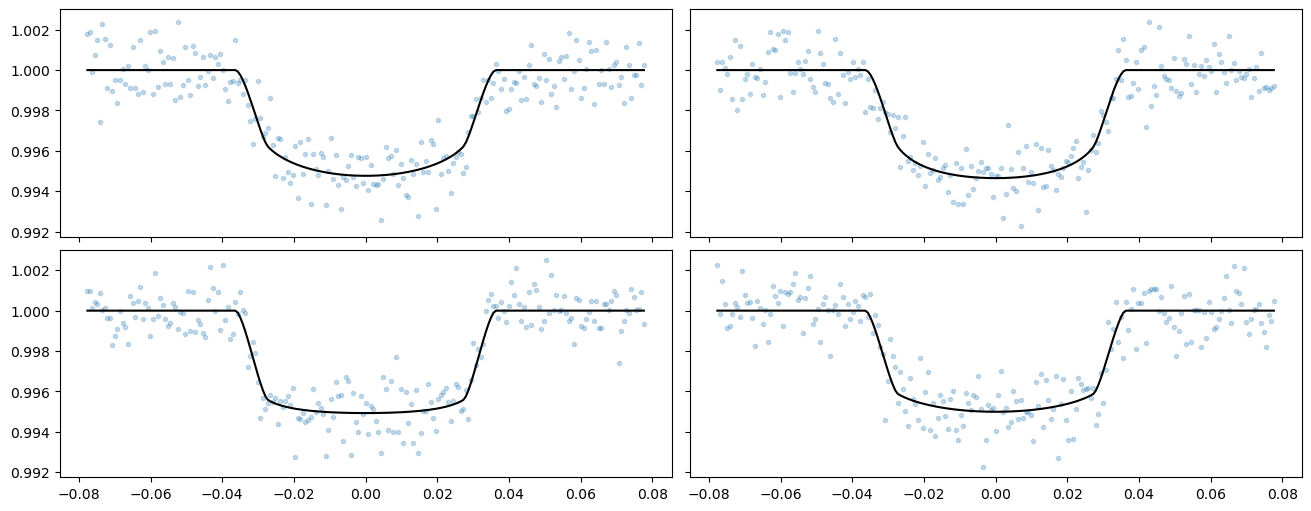

In [19]:
lc = MockLC(SimulationSetup('M', k3re, 0.65, 0.0, 'short_transit', cteff=3600))
lc.create(wnsigma=[wn, wn, wn, wn], rnsigma=0.00001, rntscale=0.5, nights=1)
lpf = MockLPF('2024_m_host_1a_no_contamination', lc)
lpf.print_parameters(1)
lpf.optimize_global(2000, npop=100, plot_convergence=False)
lpf.plot_light_curves()

In [4]:
lpf.sample_mcmc(ns, thin=50, reset=True, repeats=nr, save=True)

MCMC sampling:   0%|          | 0/10 [00:00<?, ?it/s]

Run 1/10:   0%|          | 0/15000 [00:00<?, ?it/s]

Run 2/10:   0%|          | 0/15000 [00:00<?, ?it/s]

Run 3/10:   0%|          | 0/15000 [00:00<?, ?it/s]

Run 4/10:   0%|          | 0/15000 [00:00<?, ?it/s]

Run 5/10:   0%|          | 0/15000 [00:00<?, ?it/s]

Run 6/10:   0%|          | 0/15000 [00:00<?, ?it/s]

Run 7/10:   0%|          | 0/15000 [00:00<?, ?it/s]

Run 8/10:   0%|          | 0/15000 [00:00<?, ?it/s]

Run 9/10:   0%|          | 0/15000 [00:00<?, ?it/s]

Run 10/10:   0%|          | 0/15000 [00:00<?, ?it/s]

## A super-Neptune around an M dwarf
### $\Delta T_\mathrm{Eff}$ = 0 K

Global optimisation:   0%|          | 0/2000 [00:00<?, ?it/s]

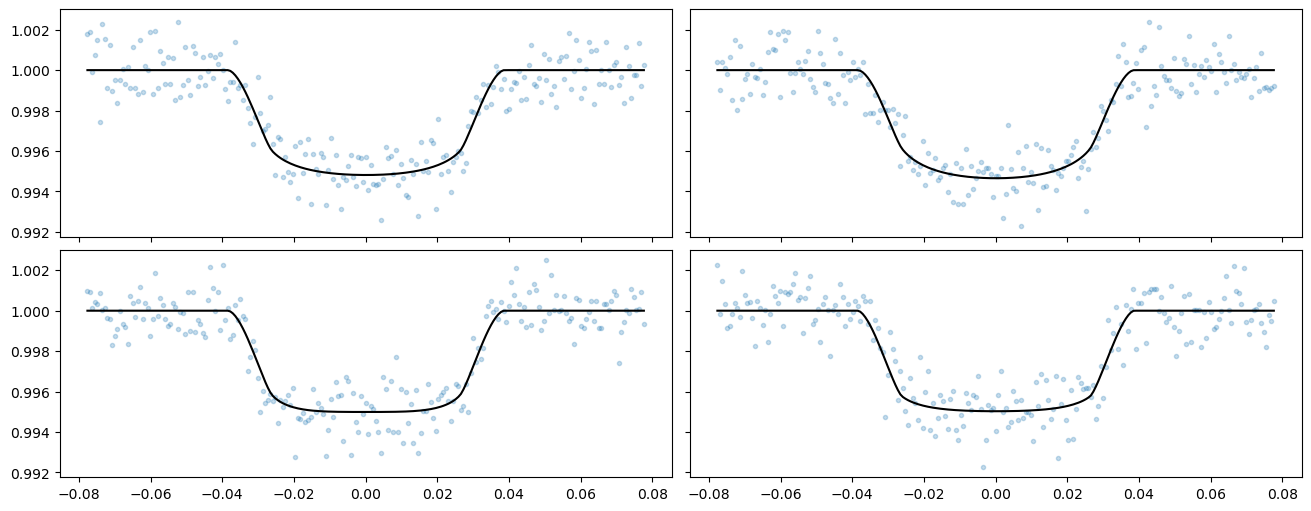

In [5]:
lc = MockLC(SimulationSetup('M', k3re, 0.65, 0.5, 'short_transit', cteff=3600))
lc.create(wnsigma=[wn, wn, wn, wn], rnsigma=0.00001, rntscale=0.5, nights=1)
lpf = MockLPF('2024_m_host_2a_c050_dt0000k', lc)
lpf.optimize_global(2000, npop=100, plot_convergence=False)
lpf.plot_light_curves()

In [6]:
lpf.sample_mcmc(ns, thin=50, reset=True, repeats=nr, save=True)

MCMC sampling:   0%|          | 0/10 [00:00<?, ?it/s]

Run 1/10:   0%|          | 0/15000 [00:00<?, ?it/s]

Run 2/10:   0%|          | 0/15000 [00:00<?, ?it/s]

Run 3/10:   0%|          | 0/15000 [00:00<?, ?it/s]

Run 4/10:   0%|          | 0/15000 [00:00<?, ?it/s]

Run 5/10:   0%|          | 0/15000 [00:00<?, ?it/s]

Run 6/10:   0%|          | 0/15000 [00:00<?, ?it/s]

Run 7/10:   0%|          | 0/15000 [00:00<?, ?it/s]

Run 8/10:   0%|          | 0/15000 [00:00<?, ?it/s]

Run 9/10:   0%|          | 0/15000 [00:00<?, ?it/s]

Run 10/10:   0%|          | 0/15000 [00:00<?, ?it/s]

### $\Delta T_\mathrm{Eff}$ = 500 K

Global optimisation:   0%|          | 0/2000 [00:00<?, ?it/s]

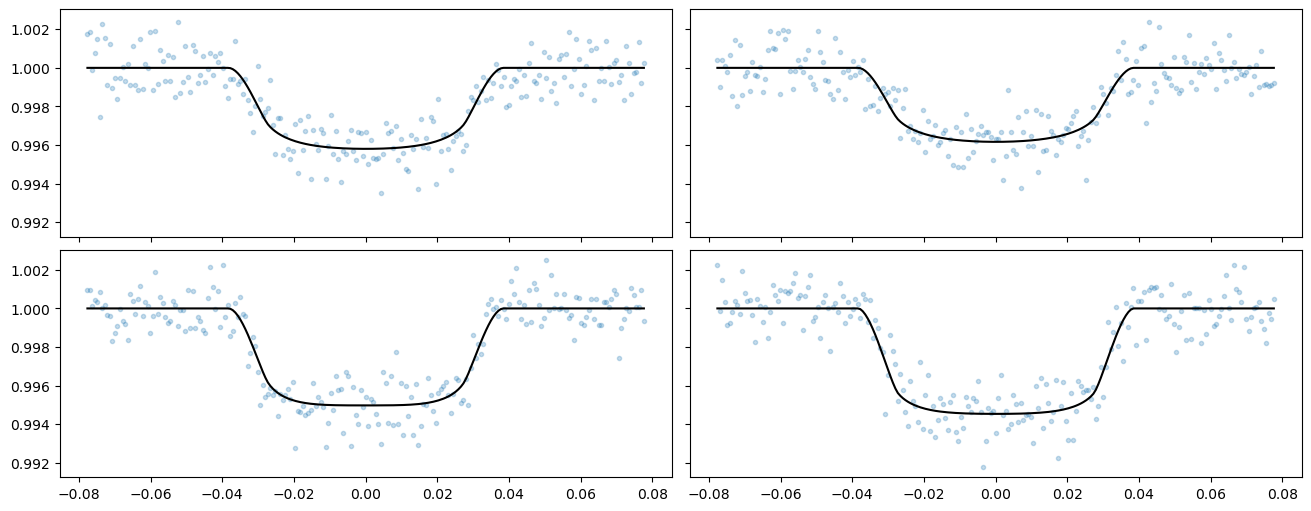

In [7]:
lc = MockLC(SimulationSetup('M', k3re, 0.65, 0.5, 'short_transit', cteff=4100))
lc.create(wnsigma=[wn, wn, wn, wn], rnsigma=0.00001, rntscale=0.5, nights=1)
lpf = MockLPF('2024_m_host_2b_c050_dt0500k', lc)
lpf.optimize_global(2000, npop=100, plot_convergence=False)
lpf.plot_light_curves()

In [8]:
lpf.sample_mcmc(ns, thin=50, reset=True, repeats=nr, save=True)

MCMC sampling:   0%|          | 0/10 [00:00<?, ?it/s]

Run 1/10:   0%|          | 0/15000 [00:00<?, ?it/s]

Run 2/10:   0%|          | 0/15000 [00:00<?, ?it/s]

Run 3/10:   0%|          | 0/15000 [00:00<?, ?it/s]

Run 4/10:   0%|          | 0/15000 [00:00<?, ?it/s]

Run 5/10:   0%|          | 0/15000 [00:00<?, ?it/s]

Run 6/10:   0%|          | 0/15000 [00:00<?, ?it/s]

Run 7/10:   0%|          | 0/15000 [00:00<?, ?it/s]

Run 8/10:   0%|          | 0/15000 [00:00<?, ?it/s]

Run 9/10:   0%|          | 0/15000 [00:00<?, ?it/s]

Run 10/10:   0%|          | 0/15000 [00:00<?, ?it/s]

### $\Delta T_\mathrm{Eff}$ = 1000 K

Global optimisation:   0%|          | 0/2000 [00:00<?, ?it/s]

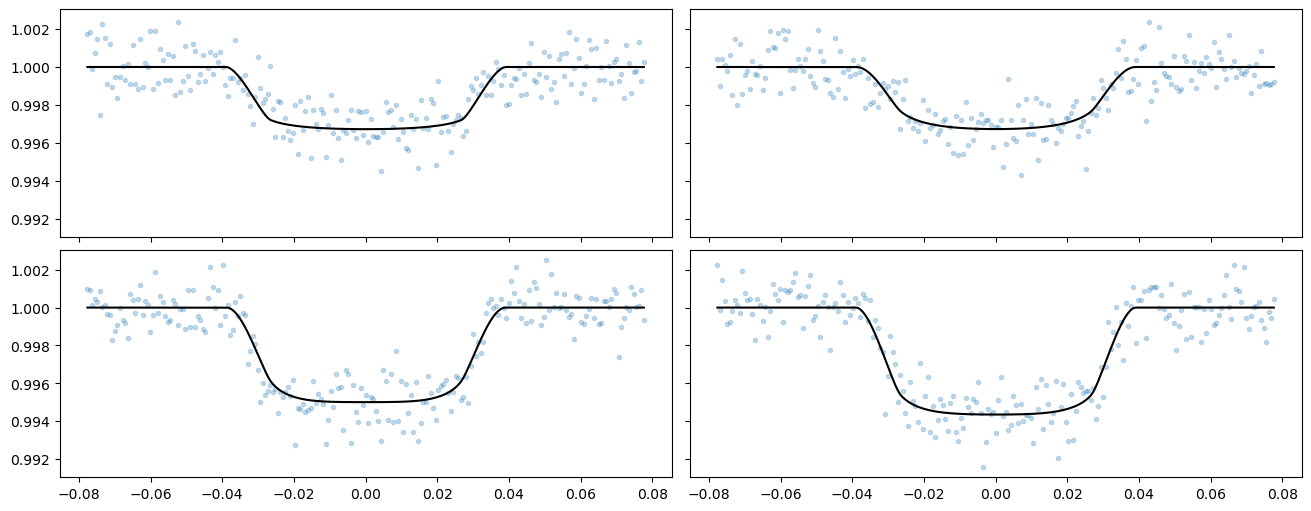

In [9]:
lc = MockLC(SimulationSetup('M', k3re, 0.65, 0.5, 'short_transit', cteff=4600))
lc.create(wnsigma=[wn, wn, wn, wn], rnsigma=0.00001, rntscale=0.5, nights=1)
lpf = MockLPF('2024_m_host_2c_c050_dt1000k', lc)
lpf.optimize_global(2000, npop=100, plot_convergence=False)
lpf.plot_light_curves()

In [10]:
lpf.sample_mcmc(ns, thin=50, reset=True, repeats=nr, save=True)

MCMC sampling:   0%|          | 0/10 [00:00<?, ?it/s]

Run 1/10:   0%|          | 0/15000 [00:00<?, ?it/s]

Run 2/10:   0%|          | 0/15000 [00:00<?, ?it/s]

Run 3/10:   0%|          | 0/15000 [00:00<?, ?it/s]

Run 4/10:   0%|          | 0/15000 [00:00<?, ?it/s]

Run 5/10:   0%|          | 0/15000 [00:00<?, ?it/s]

Run 6/10:   0%|          | 0/15000 [00:00<?, ?it/s]

Run 7/10:   0%|          | 0/15000 [00:00<?, ?it/s]

Run 8/10:   0%|          | 0/15000 [00:00<?, ?it/s]

Run 9/10:   0%|          | 0/15000 [00:00<?, ?it/s]

Run 10/10:   0%|          | 0/15000 [00:00<?, ?it/s]

## Jupiter-sized companion around an $T_\mathrm{Eff}$ = 3600 K

### $\Delta T_\mathrm{Eff}$ = 0 K

Global optimisation:   0%|          | 0/2000 [00:00<?, ?it/s]

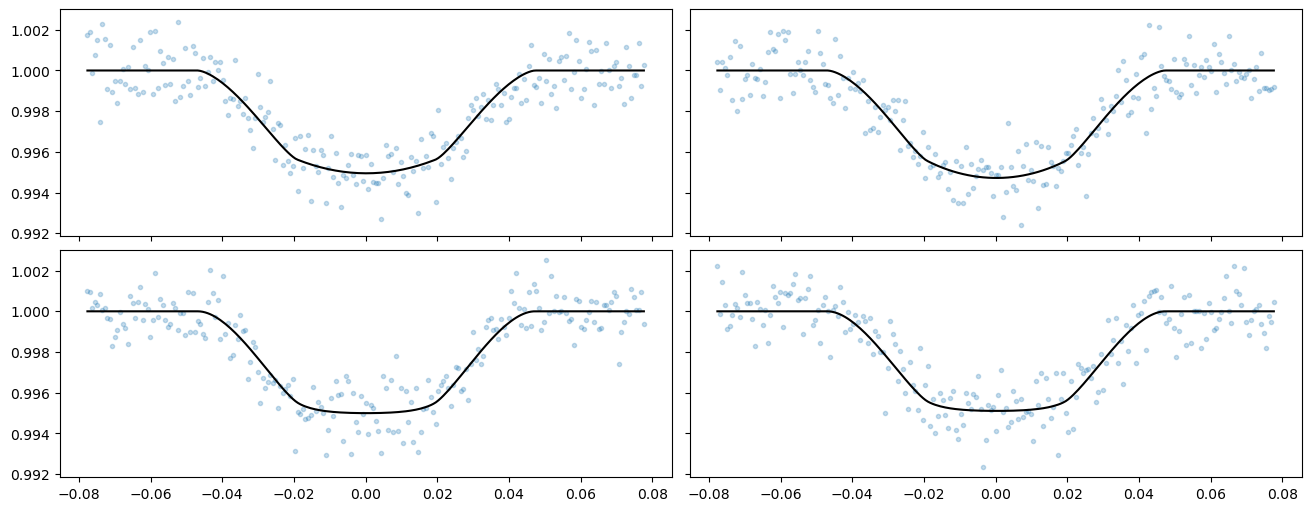

In [11]:
lc = MockLC(SimulationSetup('M', k3re, 0.65, cnt(k3re, kjup), 'short_transit', cteff=3600))
lc.create(wnsigma=[wn, wn, wn, wn], rnsigma=0.00001, rntscale=0.5, nights=1)
lpf = MockLPF('2024_m_host_3a_c093_dt0000k', lc)
lpf.optimize_global(2000, npop=100, plot_convergence=False)
lpf.plot_light_curves()

In [12]:
lpf.sample_mcmc(ns, thin=50, reset=True, repeats=nr, save=True)

MCMC sampling:   0%|          | 0/10 [00:00<?, ?it/s]

Run 1/10:   0%|          | 0/15000 [00:00<?, ?it/s]

Run 2/10:   0%|          | 0/15000 [00:00<?, ?it/s]

Run 3/10:   0%|          | 0/15000 [00:00<?, ?it/s]

Run 4/10:   0%|          | 0/15000 [00:00<?, ?it/s]

Run 5/10:   0%|          | 0/15000 [00:00<?, ?it/s]

Run 6/10:   0%|          | 0/15000 [00:00<?, ?it/s]

Run 7/10:   0%|          | 0/15000 [00:00<?, ?it/s]

Run 8/10:   0%|          | 0/15000 [00:00<?, ?it/s]

Run 9/10:   0%|          | 0/15000 [00:00<?, ?it/s]

Run 10/10:   0%|          | 0/15000 [00:00<?, ?it/s]

### $\Delta T_\mathrm{Eff}$ = 500 K

Global optimisation:   0%|          | 0/2000 [00:00<?, ?it/s]

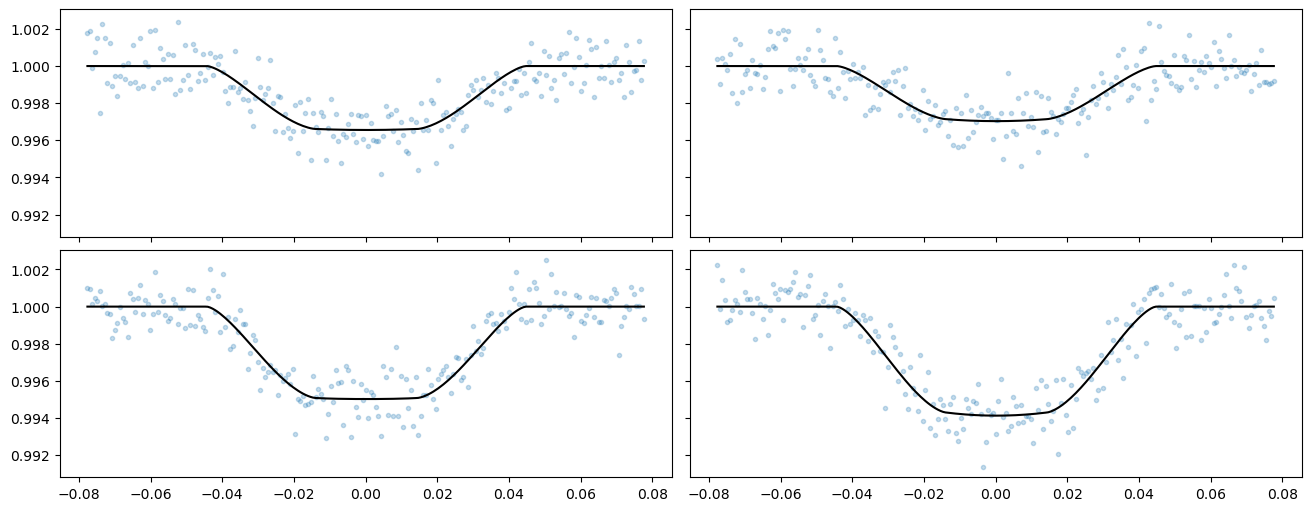

In [13]:
lc = MockLC(SimulationSetup('M', k3re, 0.65, cnt(k3re, kjup), 'short_transit', cteff=4100))
lc.create(wnsigma=[wn, wn, wn, wn], rnsigma=0.00001, rntscale=0.5, nights=1)
lpf = MockLPF('2024_m_host_3b_c093_dt0500k', lc)
lpf.optimize_global(2000, npop=100, plot_convergence=False)
lpf.plot_light_curves()

In [14]:
lpf.sample_mcmc(ns, thin=50, reset=True, repeats=nr, save=True)

MCMC sampling:   0%|          | 0/10 [00:00<?, ?it/s]

Run 1/10:   0%|          | 0/15000 [00:00<?, ?it/s]

Run 2/10:   0%|          | 0/15000 [00:00<?, ?it/s]

Run 3/10:   0%|          | 0/15000 [00:00<?, ?it/s]

Run 4/10:   0%|          | 0/15000 [00:00<?, ?it/s]

Run 5/10:   0%|          | 0/15000 [00:00<?, ?it/s]

Run 6/10:   0%|          | 0/15000 [00:00<?, ?it/s]

Run 7/10:   0%|          | 0/15000 [00:00<?, ?it/s]

Run 8/10:   0%|          | 0/15000 [00:00<?, ?it/s]

Run 9/10:   0%|          | 0/15000 [00:00<?, ?it/s]

Run 10/10:   0%|          | 0/15000 [00:00<?, ?it/s]

### $\Delta T_\mathrm{Eff}$ = 1000 K

Global optimisation:   0%|          | 0/2000 [00:00<?, ?it/s]

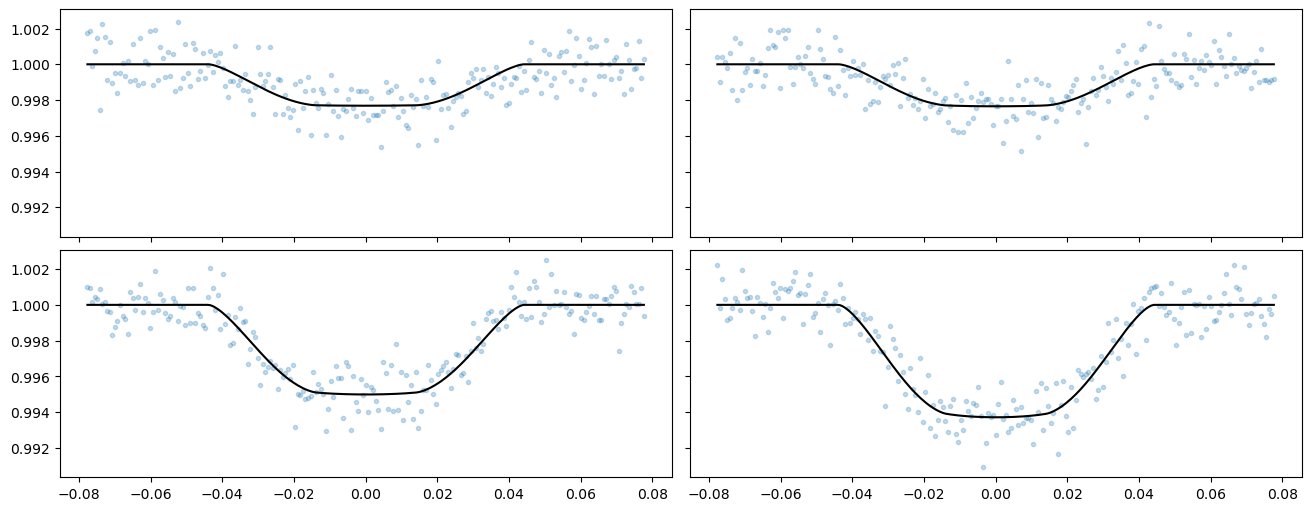

In [15]:
lc = MockLC(SimulationSetup('M', k3re, 0.65, cnt(k3re, kjup), 'short_transit', cteff=4600))
lc.create(wnsigma=[wn, wn, wn, wn], rnsigma=0.00001, rntscale=0.5, nights=1)
lpf = MockLPF('2024_m_host_3c_c093_dt1000k', lc)
lpf.optimize_global(2000, npop=100, plot_convergence=False)
lpf.plot_light_curves()

In [16]:
lpf.sample_mcmc(ns, thin=50, reset=True, repeats=nr, save=True)

MCMC sampling:   0%|          | 0/10 [00:00<?, ?it/s]

Run 1/10:   0%|          | 0/15000 [00:00<?, ?it/s]

Run 2/10:   0%|          | 0/15000 [00:00<?, ?it/s]

Run 3/10:   0%|          | 0/15000 [00:00<?, ?it/s]

Run 4/10:   0%|          | 0/15000 [00:00<?, ?it/s]

Run 5/10:   0%|          | 0/15000 [00:00<?, ?it/s]

Run 6/10:   0%|          | 0/15000 [00:00<?, ?it/s]

Run 7/10:   0%|          | 0/15000 [00:00<?, ?it/s]

Run 8/10:   0%|          | 0/15000 [00:00<?, ?it/s]

Run 9/10:   0%|          | 0/15000 [00:00<?, ?it/s]

Run 10/10:   0%|          | 0/15000 [00:00<?, ?it/s]

---
<center>&copy; 2024 Hannu Parviainen</center>